In [ ]:
%matplotlib inline

In [ ]:
!sudo -H pip install numpy pandas requests xmltodict

  Running setup.py bdist_wheel for xmltodict ... - done
  Stored in directory: /root/.cache/pip/wheels/2a/dc/70/da8958d7089d994c8614bc38210f64855f09615e85707bf615
Successfully built xmltodict


In [ ]:
import io
import json
import numpy as np
import os
import pandas as pd
import requests
import xml
import xmltodict

# Retrieve IATI Metadata

In [ ]:
# Use the IATI registry API to identify the metadata
# http://iatiregistry.org/registry-api

base_url = 'http://iatiregistry.org/api/3/action/package_search'

# Retrieve the current count by issuing a request that returns zero rows

query_data = {
    'q': 'extras_filetype:activity',
    'start': 0,
    'rows': 0
}

response = requests.get(base_url, params = query_data).json()
count = response['result']['count']

# Also print out the help text in case it helps us in the future

print response['help']


    Searches for packages satisfying a given search criteria.

    This action accepts solr search query parameters (details below), and
    returns a dictionary of results, including dictized datasets that match
    the search criteria, a search count and also facet information.

    **Solr Parameters:**

    For more in depth treatment of each paramter, please read the `Solr
    Documentation <http://wiki.apache.org/solr/CommonQueryParameters>`_.

    This action accepts a *subset* of solr's search query parameters:


    :param q: the solr query.  Optional.  Default: `"*:*"`
    :type q: string
    :param fq: any filter queries to apply.  Note: `+site_id:{ckan_site_id}`
        is added to this string prior to the query being executed.
    :type fq: string
    :param sort: sorting of the search results.  Optional.  Default:
        'relevance asc, metadata_modified desc'.  As per the solr
        documentation, this is a comma-separated string of field names and
        sort-orderi

In [ ]:
# Retrieve all the pages of metadata from the cache file (if available)
# or from the server (if no cache file is available)

if os.path.isfile('metadata.json'):
    with io.open('metadata.json', 'r', encoding = 'utf-8') as metadata_file:
        metadata = json.load(metadata_file)
else:
    metadata = []

    # Allowed page size is 100

    for i in range(0, count, 100):
        print 'Retrieved', i, 'of', count, 'results'

        query_data = {
            'q': 'extras_filetype:activity',
            'start': i,
            'rows': 100
        }

        response = requests.get(base_url, params = query_data).json()
        metadata.extend(response['result']['results'])

    print 'Retrieved', count, 'of', count, 'results'

Retrieved 0 of 4134 results
Retrieved 100 of 4134 results
Retrieved 200 of 4134 results
Retrieved 300 of 4134 results
Retrieved 400 of 4134 results
Retrieved 500 of 4134 results
Retrieved 600 of 4134 results
Retrieved 700 of 4134 results
Retrieved 800 of 4134 results
Retrieved 900 of 4134 results
Retrieved 1000 of 4134 results
Retrieved 1100 of 4134 results
Retrieved 1200 of 4134 results
Retrieved 1300 of 4134 results
Retrieved 1400 of 4134 results
Retrieved 1500 of 4134 results
Retrieved 1600 of 4134 results
Retrieved 1700 of 4134 results
Retrieved 1800 of 4134 results
Retrieved 1900 of 4134 results
Retrieved 2000 of 4134 results
Retrieved 2100 of 4134 results
Retrieved 2200 of 4134 results
Retrieved 2300 of 4134 results
Retrieved 2400 of 4134 results
Retrieved 2500 of 4134 results
Retrieved 2600 of 4134 results
Retrieved 2700 of 4134 results
Retrieved 2800 of 4134 results
Retrieved 2900 of 4134 results
Retrieved 3000 of 4134 results
Retrieved 3100 of 4134 results
Retrieved 3200 of 41

In [ ]:
# Cache the metadata to disk so that we don't have to fetch it

with open('metadata.json', 'w') as metadata_file:
    json.dump(metadata, metadata_file)

# Validate IATI Metadata

In [ ]:
# Take a quick look at the field names and get a feel for the data

df = pd.DataFrame(metadata)

df.columns.values

array([u'author', u'author_email', u'extras', u'groups', u'id', u'isopen',
       u'license_id', u'license_title', u'license_url', u'maintainer',
       u'maintainer_email', u'metadata_created', u'metadata_modified',
       u'name', u'notes', u'num_resources', u'num_tags', u'organization',
       u'owner_org', u'private', u'relationships_as_object',
       u'relationships_as_subject', u'resources', u'revision_id',
       u'revision_timestamp', u'state', u'tags', u'title',
       u'tracking_summary', u'type', u'url', u'version'], dtype=object)

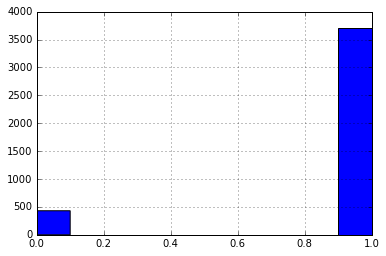

In [ ]:
# There's an isopen column indicating whether the data set is open
# to be used for general purposes. Let's see the distribution.

df['isopen'].hist()

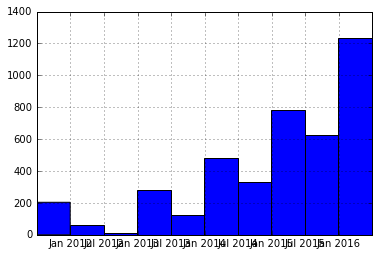

In [ ]:
# There is a metadata column on the timestamp when a revision was made,
# which we can use to see if the data is out of date or not.

pd.to_datetime(df['revision_timestamp']).hist()

# Identify Resources

In [ ]:
# Grab the URLs associated with our metadata

metadata_titles = {}
metadata_resources = {}

for metadata_item in metadata:
    if not metadata_item['isopen']:
        continue

    title = metadata_item['title']
    short_name = metadata_item['name']

    resources = metadata_item['resources']
    resource_urls = [x for x in set([resource_item['url'] for resource_item in resources])]

    metadata_titles[short_name] = title
    metadata_resources[short_name] = resource_urls

In [ ]:
# Check our metadata for duplicate URLs

for short_name, resource_urls in metadata_resources.iteritems():
    if len(resource_urls) > 1:
        print short_name
        print resource_urls

plannlno-89
[u'https://www.aidstream.org/files/xml/Plan Nederland-89.xml', u'https://aidstream.org/files/xml/Plan Nederland-89.xml']
plannlno-br
[u'https://aidstream.org/files/xml/Plan Nederland-br.xml', u'https://www.aidstream.org/files/xml/Plan Nederland-br.xml']
plannlno-bd
[u'https://www.aidstream.org/files/xml/Plan Nederland-bd.xml', u'https://aidstream.org/files/xml/Plan Nederland-bd.xml']
plannlno-ke
[u'https://aidstream.org/files/xml/Plan Nederland-ke.xml', u'https://www.aidstream.org/files/xml/Plan Nederland-ke.xml']


In [ ]:
# It looks like there are no actual duplicates, except for aidstream.org
# which has a URL listed for both aidstream.org and www.aidstream.org
# This means we should be able to safely download everything!

with io.open('download-iati.sh', 'w', encoding='utf8') as iati_file:
    iati_file.write(u'mkdir -p iati\n')

    for short_name, resource_urls in metadata_resources.iteritems():
        iati_filename = 'iati/' + short_name + '.xml'

        if os.path.isfile(iati_filename) and os.path.getsize(iati_filename) > 0:
            continue

        iati_file.write('# %s\n' % metadata_titles[short_name])
        iati_file.write('curl -Ls "%s" > %s &\n' % (resource_urls[0], iati_filename))

    iati_file.write(u'wait\n')

In [ ]:
!chmod u+x download-iati.sh
!./download-iati.sh

In [ ]:
# Clean up anything that wound up with a file size of zero

for xml_name in os.listdir('iati'):
    iati_filename = 'iati/' + xml_name

    if os.path.getsize(iati_filename) == 0:
        os.remove(iati_filename)

# Create Resource Archive

In [ ]:
!rm -f iati.tar.gz
!tar -cf iati.tar iati
!gzip iati.tar
!aws s3 cp iati.tar.gz s3://mdang.w210/

upload: ./iati.tar.gz to s3://mdang.w210/iati.tar.gz
